## **Hotel Booking Demand Prediction**


## Get the Hotel booking dataset

**1. From Kaggle:**

https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand

This data set contains booking information for a city hotel and a resort hotel, and includes information such as when the booking was made, length of stay, the number of adults, children, and/or babies, and the number of available parking spaces, among other things.

**2. From Weather API:**


**3. From Events/Holidays data API:**





In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [29]:
hotel_bookings_df = pd.read_csv('hotel_bookings.csv')
hotel_bookings_df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [30]:
hotel_bookings_df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [31]:
hotel_bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [32]:
hotel_bookings_df['market_segment'].unique()

array(['Direct', 'Corporate', 'Online TA', 'Offline TA/TO',
       'Complementary', 'Groups', 'Undefined', 'Aviation'], dtype=object)

In [35]:
hotel_bookings_df['arrival_date'] = pd.to_datetime(
    hotel_bookings_df['arrival_date_year'].astype(str) + '-' +
    hotel_bookings_df['arrival_date_month'] + '-' +
    hotel_bookings_df['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d'
)


In [36]:
# Step 2: Extract `origin_country` from the `country` column
hotel_bookings_df['origin_country'] = hotel_bookings_df['country']

# Step 3: Assign `arrival_location` based on the `hotel` column
hotel_bookings_df['arrival_location'] = hotel_bookings_df['hotel'].apply(
    lambda x: 'Lisbon, Portugal' if x == 'City Hotel' else 'Faro, Portugal'
)





In [10]:
# Prepare unique combinations for Lisbon, Portugal
lisbon_data = hotel_bookings_df[hotel_bookings_df['arrival_location'] == 'Lisbon, Portugal']
lisbon_unique = lisbon_data[['arrival_date']].drop_duplicates()

# Prepare unique combinations for Faro, Portugal
faro_data = hotel_bookings_df[hotel_bookings_df['arrival_location'] == 'Faro, Portugal']
faro_unique = faro_data[['arrival_date']].drop_duplicates()


## **Extracting Weather Data using Weather API from Visualcrossing**




In [11]:
import requests
from io import StringIO
import pandas as pd

def fetch_and_save_weather(api_key, location, start_date, end_date, output_file):
    """
    Fetch weather data for a location over a date range and save to a CSV file.

    Parameters:
    - api_key: Your Visual Crossing API key.
    - location: The location (e.g., "Lisbon, Portugal").
    - start_date: The start date (YYYY-MM-DD).
    - end_date: The end date (YYYY-MM-DD).
    - output_file: Name of the file to save the weather data.

    Returns:
    - weather_df: A DataFrame containing the weather data.
    """
    base_url = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline"
    request_url = f"{base_url}/{location}/{start_date}/{end_date}?unitGroup=metric&include=days&key={api_key}&contentType=csv"

    print(f"Fetching weather data for {location} from {start_date} to {end_date}")
    response = requests.get(request_url)

    if response.status_code == 200:
        data = StringIO(response.text)
        weather_df = pd.read_csv(data)
        # Save to CSV
        weather_df.to_csv(output_file, index=False)
        print(f"Weather data saved to '{output_file}'")
        return weather_df
    else:
        print(f"Failed to fetch data for {location}: {response.status_code}")
        return None


In [12]:
# # Configuration
# api_key = "NG4YBQ7MRFZLMHM6G8N3KSF8H"

# # Date ranges for Lisbon and Faro
# lisbon_start_date = lisbon_unique['arrival_date'].min().strftime('%Y-%m-%d')
# lisbon_end_date = lisbon_unique['arrival_date'].max().strftime('%Y-%m-%d')
# faro_start_date = faro_unique['arrival_date'].min().strftime('%Y-%m-%d')
# faro_end_date = faro_unique['arrival_date'].max().strftime('%Y-%m-%d')

# # Fetch weather data for Lisbon
# lisbon_weather_df = fetch_and_save_weather(
#     api_key, "Lisbon, Portugal", lisbon_start_date, lisbon_end_date, "lisbon_weather.csv"
# )

# # Fetch weather data for Faro
# faro_weather_df = fetch_and_save_weather(
#     api_key, "Faro, Portugal", faro_start_date, faro_end_date, "faro_weather.csv"
# )


Fetching weather data for Lisbon, Portugal from 2015-07-01 to 2017-08-31
Weather data saved to 'lisbon_weather.csv'
Fetching weather data for Faro, Portugal from 2015-07-01 to 2017-08-31
Weather data saved to 'faro_weather.csv'


In [13]:
# Combine Lisbon and Faro weather data
if lisbon_weather_df is not None and faro_weather_df is not None:
    combined_weather_df = pd.concat([lisbon_weather_df, faro_weather_df], ignore_index=True)
    combined_weather_df.to_csv('combined_weather_data.csv', index=False)
    print("Combined weather data saved to 'combined_weather_data.csv'")
else:
    print("Failed to fetch weather data for one or more locations.")


Combined weather data saved to 'combined_weather_data.csv'


In [17]:
combined_weather_df.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [ ]:
# # Save the combined weather data to a CSV file
# combined_weather_df.to_csv('combined_weather_data.csv', index=False)
# print("Combined weather data saved to 'combined_weather_data.csv'.")


In [18]:
def process_combined_weather_data(weather_df):
    """
    Select and rename relevant columns from the combined weather data.
    """
    weather_df['forecast_date'] = pd.to_datetime(weather_df['datetime']).dt.date

    return weather_df[[
        'forecast_date',  # Date of the weather data
        'name',       # Location of the weather data
        'temp',           # Average temperature
        'tempmin',        # Minimum temperature
        'tempmax',        # Maximum temperature
        'feelslike',      # Average "feels like" temperature
        'humidity',       # Humidity level as a percentage
        'precip',         # Total precipitation in mm
        'precipprob',     # Probability of precipitation
        'snow',           # Snowfall amount in mm
        'windgust',       # Maximum wind gust speed in km/h
        'windspeed',      # Average wind speed in km/h
        'visibility',     # Visibility in km
        'cloudcover',     # Percentage of cloud cover
        'conditions',     # General weather conditions (e.g., "Rain", "Cloudy")
    ]].rename(columns={
        'temp': 'avg_temp',
        'tempmin': 'min_temp',
        'tempmax': 'max_temp',
        'feelslike': 'feels_like_temp',
        'precip': 'precipitation',
        'precipprob': 'precipitation_probability',
        'snow': 'snowfall',
        'windgust': 'max_wind_gust',
        'windspeed': 'avg_wind_speed',
        'visibility': 'visibility_km',
        'cloudcover': 'cloud_cover',
        'conditions': 'weather_conditions'
    })


In [19]:
# # Process the combined weather data
# processed_weather_df = process_combined_weather_data(combined_weather_df)

# # Save the processed data
# processed_weather_df.to_csv('processed_combined_weather_data.csv', index=False)
# print("Processed combined weather data saved to 'processed_combined_weather_data.csv'.")


Processed combined weather data saved to 'processed_combined_weather_data.csv'.


In [37]:
processed_weather_df = pd.read_csv('processed_combined_weather_data.csv')

processed_weather_df['name'] = processed_weather_df['name'].apply(lambda x: 'Lisbon, Portugal' if x == 'Lisboa, Portugal' else 'Faro, Portugal')

In [38]:
# Convert forecast_date to datetime
processed_weather_df['forecast_date'] = pd.to_datetime(processed_weather_df['forecast_date'])

processed_weather_df = processed_weather_df.rename(columns={'name': 'location'})

# Ensure location column is clean
print(processed_weather_df[['forecast_date', 'location']].head())


  forecast_date          location
0    2015-07-01  Lisbon, Portugal
1    2015-07-02  Lisbon, Portugal
2    2015-07-03  Lisbon, Portugal
3    2015-07-04  Lisbon, Portugal
4    2015-07-05  Lisbon, Portugal


In [39]:
# Convert arrival_date to datetime
hotel_bookings_df['arrival_date'] = pd.to_datetime(hotel_bookings_df['arrival_date'])

# Ensure arrival_location is clean
print(hotel_bookings_df[['arrival_date', 'arrival_location']].head())


  arrival_date arrival_location
0   2015-07-01   Faro, Portugal
1   2015-07-01   Faro, Portugal
2   2015-07-01   Faro, Portugal
3   2015-07-01   Faro, Portugal
4   2015-07-01   Faro, Portugal


In [40]:
hotel_bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 35 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_year               119390 non-null  int64         
 4   arrival_date_month              119390 non-null  object        
 5   arrival_date_week_number        119390 non-null  int64         
 6   arrival_date_day_of_month       119390 non-null  int64         
 7   stays_in_weekend_nights         119390 non-null  int64         
 8   stays_in_week_nights            119390 non-null  int64         
 9   adults                          119390 non-null  int64         
 10  children                        119386 non-null  float64

In [41]:
hotel_bookings_df_orig = hotel_bookings_df.copy()

In [42]:
# Join weather data to hotel bookings data
hotel_bookings_df = pd.merge(
    hotel_bookings_df_orig,
    processed_weather_df,
    left_on=['arrival_location', 'arrival_date'],
    right_on=['location', 'forecast_date'],
    how='left'
)

# Drop redundant columns after the merge
hotel_bookings_df = hotel_bookings_df.drop(columns=['location', 'forecast_date'])

# Preview the merged dataset
print(hotel_bookings_df.head())


          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        0                     0       2  ...   
1                        0        

In [43]:
hotel_bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 48 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_year               119390 non-null  int64         
 4   arrival_date_month              119390 non-null  object        
 5   arrival_date_week_number        119390 non-null  int64         
 6   arrival_date_day_of_month       119390 non-null  int64         
 7   stays_in_weekend_nights         119390 non-null  int64         
 8   stays_in_week_nights            119390 non-null  int64         
 9   adults                          119390 non-null  int64         
 10  children                        119386 non-null  float64

In [44]:
# # Save the updated dataset to a CSV file
# hotel_bookings_df.to_csv('hotel_bookings_with_weather.csv', index=False)
# print("Merged dataset saved to 'hotel_bookings_with_weather.csv'.")


Merged dataset saved to 'hotel_bookings_with_weather.csv'.


In [45]:
# hotel_bookings_df = pd.read_csv('hotel_bookings_with_weather.csv')

## **Extract Event or Holiday data for Portugal from 2015 to 2017 using RapidAPI**

In [ ]:
import requests
import pandas as pd

def fetch_public_holidays(api_key, country_code, years):
    """
    Fetch public holiday data for a given country and a range of years.
    Parameters:
    - api_key: Your RapidAPI key.
    - country_code: Country code (e.g., 'PT' for Portugal).
    - years: List of years to fetch data for (e.g., [2015, 2016, 2017]).
    Returns:
    - holidays_df: A DataFrame containing holiday data for all years.
    """
    url_template = "https://public-holidays7.p.rapidapi.com/{year}/{country}"
    headers = {
        "x-rapidapi-key": api_key,
        "x-rapidapi-host": "public-holidays7.p.rapidapi.com"
    }

    holidays_list = []

    for year in years:
        url = url_template.format(year=year, country=country_code)
        response = requests.get(url, headers=headers)

        if response.status_code == 200:
            holidays = response.json()
            for holiday in holidays:
                holidays_list.append({
                    "name": holiday.get("name", ""),
                    "date": holiday.get("date", ""),
                    "localName": holiday.get("localName", ""),
                    "countryCode": country_code,
                    "year": year
                })
        else:
            print(f"Failed to fetch data for {country_code} in {year}: {response.status_code}")

    # Convert the list of holidays into a DataFrame
    holidays_df = pd.DataFrame(holidays_list)
    return holidays_df

# Configuration
api_key = "823d0c4142msh2a3a354852b3a4ep13402djsn9c823368e0dd"  # Replace with your API key
country_code = "PT"  # Portugal
years = [2015, 2016, 2017]  # List of years to fetch




In [ ]:
# Fetch holiday data
# holidays_df = fetch_public_holidays(api_key, country_code, years)

# # Save to CSV
# holidays_df.to_csv('portugal_holidays_2015_2017.csv', index=False)

# # Preview the holiday data
# print(holidays_df.head())

             name        date          localName countryCode  year
0  New Year's Day  2015-01-01           Ano Novo          PT  2015
1        Carnival  2015-02-17           Carnaval          PT  2015
2     Good Friday  2015-04-03  Sexta-feira Santa          PT  2015
3   Easter Sunday  2015-04-05  Domingo de Páscoa          PT  2015
4     Freedom Day  2015-04-25   Dia da Liberdade          PT  2015


In [46]:
holidays_df = pd.read_csv('portugal_holidays_2015_2017.csv')

In [47]:
# Convert holiday dates to datetime format
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

# Preview the holiday data
print(holidays_df.head())


             name       date          localName countryCode  year
0  New Year's Day 2015-01-01           Ano Novo          PT  2015
1        Carnival 2015-02-17           Carnaval          PT  2015
2     Good Friday 2015-04-03  Sexta-feira Santa          PT  2015
3   Easter Sunday 2015-04-05  Domingo de Páscoa          PT  2015
4     Freedom Day 2015-04-25   Dia da Liberdade          PT  2015


In [48]:
# Convert arrival_date to datetime format
hotel_bookings_df['arrival_date'] = pd.to_datetime(hotel_bookings_df['arrival_date'])

# Preview the booking data
print(hotel_bookings_df.head())


          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  \
0                        0                     0       2  ...   
1                        0        

In [49]:
# Create a flag for whether the arrival date is in a holiday week
hotel_bookings_df['is_holiday_week'] = hotel_bookings_df['arrival_date'].apply(
    lambda arrival_date: holidays_df['date'].apply(
        lambda holiday_date: abs((arrival_date - holiday_date).days) <= 7
    ).any()
)

# Preview the updated dataset
print(hotel_bookings_df[['arrival_date', 'is_holiday_week']].head())


  arrival_date  is_holiday_week
0   2015-07-01             True
1   2015-07-01             True
2   2015-07-01             True
3   2015-07-01             True
4   2015-07-01             True


In [50]:
hotel_bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 49 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_year               119390 non-null  int64         
 4   arrival_date_month              119390 non-null  object        
 5   arrival_date_week_number        119390 non-null  int64         
 6   arrival_date_day_of_month       119390 non-null  int64         
 7   stays_in_weekend_nights         119390 non-null  int64         
 8   stays_in_week_nights            119390 non-null  int64         
 9   adults                          119390 non-null  int64         
 10  children                        119386 non-null  float64

In [51]:
# Function to find the nearest holiday
def find_nearest_holiday(arrival_date, holidays_df):
    holidays_df['days_diff'] = (holidays_df['date'] - arrival_date).abs().dt.days
    nearest_holiday = holidays_df.loc[holidays_df['days_diff'].idxmin()]
    return nearest_holiday['name'], nearest_holiday['days_diff']

# Add nearest holiday and days to holiday
nearest_holidays = hotel_bookings_df['arrival_date'].apply(lambda x: find_nearest_holiday(x, holidays_df))
hotel_bookings_df['nearest_holiday'] = nearest_holidays.apply(lambda x: x[0])
hotel_bookings_df['days_to_holiday'] = nearest_holidays.apply(lambda x: x[1])

# Preview the updated dataset
print(hotel_bookings_df[['arrival_date', 'is_holiday_week', 'nearest_holiday', 'days_to_holiday']].head())


  arrival_date  is_holiday_week nearest_holiday  days_to_holiday
0   2015-07-01             True     Madeira Day                0
1   2015-07-01             True     Madeira Day                0
2   2015-07-01             True     Madeira Day                0
3   2015-07-01             True     Madeira Day                0
4   2015-07-01             True     Madeira Day                0


In [52]:
hotel_bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 51 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_year               119390 non-null  int64         
 4   arrival_date_month              119390 non-null  object        
 5   arrival_date_week_number        119390 non-null  int64         
 6   arrival_date_day_of_month       119390 non-null  int64         
 7   stays_in_weekend_nights         119390 non-null  int64         
 8   stays_in_week_nights            119390 non-null  int64         
 9   adults                          119390 non-null  int64         
 10  children                        119386 non-null  float64

In [53]:
# hotel_bookings_df.to_csv('hotel_bookings_with_weather_and_holidays.csv', index=False)
# print("Merged dataset with holiday data saved to 'hotel_bookings_with_weather_and_holidays.csv'.")

Merged dataset with holiday data saved to 'hotel_bookings_with_weather_and_holidays.csv'.


In [4]:
final_hotel_bookings_df = pd.read_csv('hotel_bookings_with_weather_and_holidays.csv')

In [5]:
final_hotel_bookings_df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,precipitation_probability,snowfall,max_wind_gust,avg_wind_speed,visibility_km,cloud_cover,weather_conditions,is_holiday_week,nearest_holiday,days_to_holiday
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,2017,August,35,30,2,5,2,...,0,0,45.7,24.1,11.0,30.2,Partially cloudy,False,Assumption Day,15
119386,City Hotel,0,102,2017,August,35,31,2,5,3,...,0,0,47.2,31.1,12.0,22.2,Partially cloudy,False,Assumption Day,16
119387,City Hotel,0,34,2017,August,35,31,2,5,2,...,0,0,47.2,31.1,12.0,22.2,Partially cloudy,False,Assumption Day,16
119388,City Hotel,0,109,2017,August,35,31,2,5,2,...,0,0,47.2,31.1,12.0,22.2,Partially cloudy,False,Assumption Day,16


In [6]:
final_hotel_bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 51 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [7]:
final_hotel_bookings_df['arrival_location'].unique()

array(['Faro, Portugal', 'Lisbon, Portugal'], dtype=object)

## **Data Cleaning**

In [8]:
null = pd.DataFrame({'Null Values' : final_hotel_bookings_df.isna().sum(), 'Percentage Null Values' : (final_hotel_bookings_df.isna().sum()) / (final_hotel_bookings_df.shape[0]) * (100)})
null

,Null Values,Percentage Null Values
hotel,0,0.000000
is_canceled,0,0.000000
lead_time,0,0.000000
arrival_date_year,0,0.000000
arrival_date_month,0,0.000000
arrival_date_week_number,0,0.000000
arrival_date_day_of_month,0,0.000000
stays_in_weekend_nights,0,0.000000
stays_in_week_nights,0,0.000000
adults,0,0.000000


In [9]:
final_hotel_bookings_df['company'].value_counts()

,count
company,
40.0,927
223.0,784
67.0,267
45.0,250
153.0,215
...,...
104.0,1
531.0,1
160.0,1


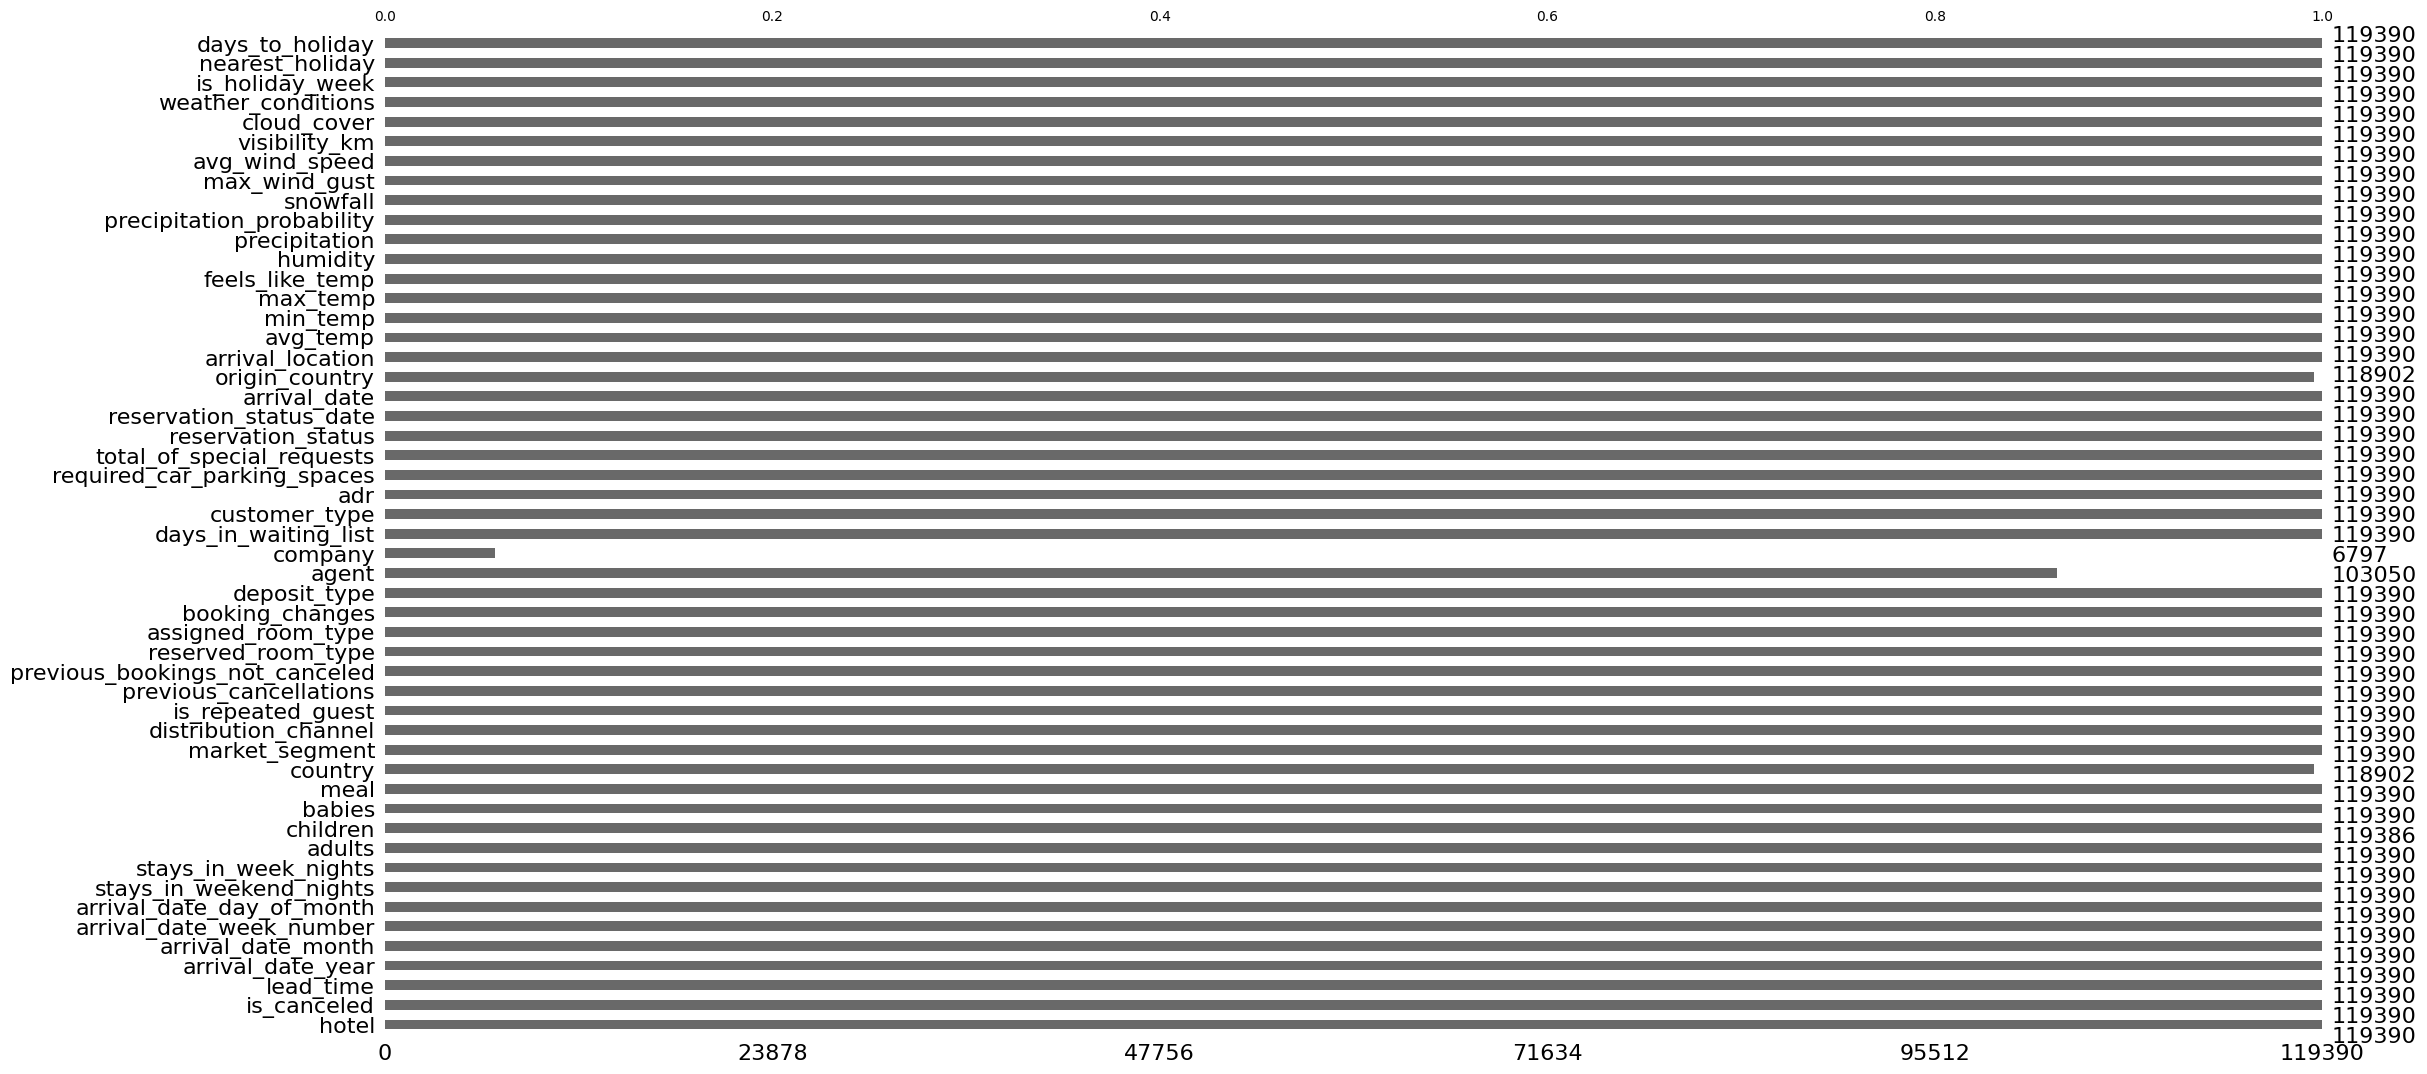

In [10]:
import missingno as msno

# visualizing null values
msno.bar(final_hotel_bookings_df)
plt.show()

**Dropping Duplicates**

In [11]:
final_hotel_bookings_df[final_hotel_bookings_df.duplicated()]

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,precipitation_probability,snowfall,max_wind_gust,avg_wind_speed,visibility_km,cloud_cover,weather_conditions,is_holiday_week,nearest_holiday,days_to_holiday
5,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
22,Resort Hotel,0,72,2015,July,27,1,2,4,2,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
43,Resort Hotel,0,70,2015,July,27,2,2,3,2,...,0,0,39.6,25.5,12.0,2.0,Clear,True,Madeira Day,1
138,Resort Hotel,1,5,2015,July,28,5,1,0,2,...,0,0,37.4,21.1,11.9,5.0,Clear,True,Madeira Day,4
200,Resort Hotel,0,0,2015,July,28,7,0,1,1,...,0,0,36.4,20.2,11.7,10.2,Clear,True,Madeira Day,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119349,City Hotel,0,186,2017,August,35,31,0,3,2,...,0,0,47.2,31.1,12.0,22.2,Partially cloudy,False,Assumption Day,16
119352,City Hotel,0,63,2017,August,35,31,0,3,3,...,0,0,47.2,31.1,12.0,22.2,Partially cloudy,False,Assumption Day,16
119353,City Hotel,0,63,2017,August,35,31,0,3,3,...,0,0,47.2,31.1,12.0,22.2,Partially cloudy,False,Assumption Day,16
119354,City Hotel,0,63,2017,August,35,31,0,3,3,...,0,0,47.2,31.1,12.0,22.2,Partially cloudy,False,Assumption Day,16


In [12]:
final_hotel_bookings_df.duplicated().sum()

31994

In [13]:
final_hotel_bookings_df = final_hotel_bookings_df.drop_duplicates()

In [14]:
final_hotel_bookings_df.duplicated().sum()

0

**Dropping Columns**

In [15]:
final_hotel_bookings_df.columns.values

array(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date',
       'origin_country', 'arrival_location', 'avg_temp', 'min_temp',
       'max_temp', 'feels_like_temp', 'humidity', 'precipitation',
       'precipitation_probability', 'snowfall', 'max_wind_gust',
       'avg_wind_speed', 'visibility_km', 'cloud_cover',
       'weather_conditions', 'i

In [16]:
final_hotel_bookings_df.drop('company',inplace=True,axis=1)
# final_hotel_bookings_df.drop('arrival_date_week_number',inplace=True,axis=1)
# final_hotel_bookings_df.drop('arrival_date_year',inplace=True,axis=1)
# final_hotel_bookings_df.drop('arrival_date_month',inplace=True,axis=1)
# final_hotel_bookings_df.drop('arrival_date_day_of_month',inplace=True,axis=1)

<ipython-input-16-d8f2d49b1254>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_hotel_bookings_df.drop('company',inplace=True,axis=1)


In [17]:
final_hotel_bookings_df.drop('origin_country',inplace=True,axis=1)

<ipython-input-17-37bef889331b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_hotel_bookings_df.drop('origin_country',inplace=True,axis=1)


In [18]:
final_hotel_bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87396 entries, 0 to 119389
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           87396 non-null  object 
 1   is_canceled                     87396 non-null  int64  
 2   lead_time                       87396 non-null  int64  
 3   arrival_date_year               87396 non-null  int64  
 4   arrival_date_month              87396 non-null  object 
 5   arrival_date_week_number        87396 non-null  int64  
 6   arrival_date_day_of_month       87396 non-null  int64  
 7   stays_in_weekend_nights         87396 non-null  int64  
 8   stays_in_week_nights            87396 non-null  int64  
 9   adults                          87396 non-null  int64  
 10  children                        87392 non-null  float64
 11  babies                          87396 non-null  int64  
 12  meal                            8739

**Handling Missing Values**

In [19]:
final_hotel_bookings_df['children'] = final_hotel_bookings_df['children'].fillna(final_hotel_bookings_df['children'].median())
final_hotel_bookings_df['agent'] = final_hotel_bookings_df['agent'].fillna(final_hotel_bookings_df['agent'].median())

<ipython-input-19-9a00276c30b7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_hotel_bookings_df['children'] = final_hotel_bookings_df['children'].fillna(final_hotel_bookings_df['children'].median())
<ipython-input-19-9a00276c30b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_hotel_bookings_df['agent'] = final_hotel_bookings_df['agent'].fillna(final_hotel_bookings_df['agent'].median())


In [20]:
# find which country is more frequent in our data
print(final_hotel_bookings_df['country'].mode())


0    PRT
Name: country, dtype: object


In [21]:
final_hotel_bookings_df['country'].fillna(final_hotel_bookings_df['country'].mode()[0], inplace=True)

<ipython-input-21-78b48c7fcc05>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_hotel_bookings_df['country'].fillna(final_hotel_bookings_df['country'].mode()[0], inplace=True)
<ipython-input-21-78b48c7fcc05>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_hotel_bookings_df['country'].fillna(final_hotel_bookings_df['country'].mode

In [22]:
null_counts = final_hotel_bookings_df.isnull().sum().reset_index()
null_counts.columns = ['Column', 'MissingValues']
null_counts

,Column,MissingValues
0,hotel,0
1,is_canceled,0
2,lead_time,0
3,arrival_date_year,0
4,arrival_date_month,0
5,arrival_date_week_number,0
6,arrival_date_day_of_month,0
7,stays_in_weekend_nights,0
8,stays_in_week_nights,0
9,adults,0


**Check for Miswritings**

In [23]:
df_cleaned = pd.DataFrame(final_hotel_bookings_df, columns=["hotel",  "country", "market_segment", "distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "customer_type", "reservation_status"])
for col in df_cleaned:
   print(col, df_cleaned[col].unique())

hotel ['Resort Hotel' 'City Hotel']
country ['PRT' 'GBR' 'USA' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'OMN' 'ARG' 'POL' 'DEU'
 'BEL' 'CHE' 'CN' 'GRC' 'ITA' 'NLD' 'DNK' 'RUS' 'SWE' 'AUS' 'EST' 'CZE'
 'BRA' 'FIN' 'MOZ' 'BWA' 'LUX' 'SVN' 'ALB' 'IND' 'CHN' 'MEX' 'MAR' 'UKR'
 'SMR' 'LVA' 'PRI' 'SRB' 'CHL' 'AUT' 'BLR' 'LTU' 'TUR' 'ZAF' 'AGO' 'ISR'
 'CYM' 'ZMB' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN' 'ARE' 'TUN' 'JAM' 'HRV'
 'HKG' 'IRN' 'GEO' 'AND' 'GIB' 'URY' 'JEY' 'CAF' 'CYP' 'COL' 'GGY' 'KWT'
 'NGA' 'MDV' 'VEN' 'SVK' 'FJI' 'KAZ' 'PAK' 'IDN' 'LBN' 'PHL' 'SEN' 'SYC'
 'AZE' 'BHR' 'NZL' 'THA' 'DOM' 'MKD' 'MYS' 'ARM' 'JPN' 'LKA' 'CUB' 'CMR'
 'BIH' 'MUS' 'COM' 'SUR' 'UGA' 'BGR' 'CIV' 'JOR' 'SYR' 'SGP' 'BDI' 'SAU'
 'VNM' 'PLW' 'QAT' 'EGY' 'PER' 'MLT' 'MWI' 'ECU' 'MDG' 'ISL' 'UZB' 'NPL'
 'BHS' 'MAC' 'TGO' 'TWN' 'DJI' 'STP' 'KNA' 'ETH' 'IRQ' 'HND' 'RWA' 'KHM'
 'MCO' 'BGD' 'IMN' 'TJK' 'NIC' 'BEN' 'VGB' 'TZA' 'GAB' 'GHA' 'TMP' 'GLP'
 'KEN' 'LIE' 'GNB' 'MNE' 'UMI' 'MYT' 'FRO' 'MMR' 'PAN' 'BFA' 'LBY' 'MLI'
 'NAM' '

**Drop Rows with logical errors**

In [24]:
count_0 = final_hotel_bookings_df[(final_hotel_bookings_df.children == 0) & (final_hotel_bookings_df.adults == 0) & (final_hotel_bookings_df.babies == 0)].shape[0]
count_0

166

In [25]:
logic_error = final_hotel_bookings_df[(final_hotel_bookings_df['children'] == 0) & (final_hotel_bookings_df['adults'] == 0) & (final_hotel_bookings_df['babies'] == 0)].index
final_hotel_bookings_df.drop(logic_error , inplace=True)

final_hotel_bookings_df.reset_index(drop=True, inplace=True)
final_hotel_bookings_df.head()

<ipython-input-25-5e1f09657feb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_hotel_bookings_df.drop(logic_error , inplace=True)


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,precipitation_probability,snowfall,max_wind_gust,avg_wind_speed,visibility_km,cloud_cover,weather_conditions,is_holiday_week,nearest_holiday,days_to_holiday
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0


In [26]:
count_0 = final_hotel_bookings_df[(final_hotel_bookings_df.children == 0) & (final_hotel_bookings_df.adults == 0) & (final_hotel_bookings_df.babies == 0)].shape[0]
count_0

0

**Save the Cleaned Dataset**

In [72]:
# final_hotel_bookings_df.to_csv('final_hotel_bookings_df_cleaned.csv', index=False)

In [27]:
final_hotel_bookings_df

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,precipitation_probability,snowfall,max_wind_gust,avg_wind_speed,visibility_km,cloud_cover,weather_conditions,is_holiday_week,nearest_holiday,days_to_holiday
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87225,City Hotel,0,23,2017,August,35,30,2,5,2,...,0,0,45.7,24.1,11.0,30.2,Partially cloudy,False,Assumption Day,15
87226,City Hotel,0,102,2017,August,35,31,2,5,3,...,0,0,47.2,31.1,12.0,22.2,Partially cloudy,False,Assumption Day,16
87227,City Hotel,0,34,2017,August,35,31,2,5,2,...,0,0,47.2,31.1,12.0,22.2,Partially cloudy,False,Assumption Day,16
87228,City Hotel,0,109,2017,August,35,31,2,5,2,...,0,0,47.2,31.1,12.0,22.2,Partially cloudy,False,Assumption Day,16


In [32]:
final_hotel_bookings_df = pd.read_csv('final_hotel_bookings_df_cleaned.csv')

In [33]:

final_hotel_bookings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87230 entries, 0 to 87229
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           87230 non-null  object 
 1   is_canceled                     87230 non-null  int64  
 2   lead_time                       87230 non-null  int64  
 3   arrival_date_year               87230 non-null  int64  
 4   arrival_date_month              87230 non-null  object 
 5   arrival_date_week_number        87230 non-null  int64  
 6   arrival_date_day_of_month       87230 non-null  int64  
 7   stays_in_weekend_nights         87230 non-null  int64  
 8   stays_in_week_nights            87230 non-null  int64  
 9   adults                          87230 non-null  int64  
 10  children                        87230 non-null  float64
 11  babies                          87230 non-null  int64  
 12  meal                            

## **EDA**

**What are the main countries or regions guests travel from?**

In [34]:
# get number of acutal guests by country
country_data = pd.DataFrame(final_hotel_bookings_df.loc[final_hotel_bookings_df["is_canceled"] == 0]["country"].value_counts().reset_index())
country_data.columns = ["country", "Number of Guests"]
#country_data.set_index("country", inplace=True
#country_data.index.name = "country"
#country_data.rename(columns={"country": "Number of Guests"}, inplace=True)


In [35]:
country_data

,country,Number of Guests
0,PRT,17991
1,GBR,8440
2,FRA,7091
3,ESP,5382
4,DEU,4332
...,...,...
160,ZMB,1
161,SYC,1
162,MDG,1
163,SMR,1


In [36]:
total_guests = country_data["Number of Guests"].sum()
country_data["Guests in %"] = round(country_data["Number of Guests"] / total_guests * 100, 2)
# country_data["country"] = country_data.index
#country_data.loc[country_data["Guests in %"] < 2, "country"] = "Other"

# pie plot
fig = px.pie(country_data,
             values="Number of Guests",
             names="country",
             title="Home country of guests",
             template="seaborn")
fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

In [37]:
# show on map
guest_map = px.choropleth(country_data,
                    locations=country_data['country'],
                    color=country_data["Guests in %"],
                    hover_name=country_data['country'],
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Home country of guests")
guest_map.show()

**How much do guests pay for a room per night?**

In [38]:
data = final_hotel_bookings_df[final_hotel_bookings_df['is_canceled'] == 0]

px.box(data_frame = data, x = 'reserved_room_type', y = 'adr', color = 'hotel', title = 'ADR per room night',template = 'plotly_dark')

**How does the price vary per night over the year?**

In [39]:
data_resort = final_hotel_bookings_df[(final_hotel_bookings_df['hotel'] == 'Resort Hotel') & (final_hotel_bookings_df['is_canceled'] == 0)]
data_city = final_hotel_bookings_df[(final_hotel_bookings_df['hotel'] == 'City Hotel') & (final_hotel_bookings_df['is_canceled'] == 0)]

In [40]:
resort_hotel = data_resort.groupby(['arrival_date_month'])['adr'].mean().reset_index()
resort_hotel

,arrival_date_month,adr
0,April,76.841664
1,August,182.103524
2,December,64.072826
3,February,53.624311
4,January,48.599615
5,July,150.914540
6,June,109.026942
7,March,57.110018
8,May,77.725129
9,November,48.956548


In [41]:
city_hotel=data_city.groupby(['arrival_date_month'])['adr'].mean().reset_index()
city_hotel

,arrival_date_month,adr
0,April,114.251636
1,August,122.825388
2,December,90.769559
3,February,88.210810
4,January,83.378062
5,July,120.069489
6,June,120.673753
7,March,91.306933
8,May,124.825944
9,November,88.271089


In [42]:
final_hotel = resort_hotel.merge(city_hotel, on = 'arrival_date_month')
final_hotel.columns = ['month', 'price_for_resort', 'price_for_city_hotel']
final_hotel

,month,price_for_resort,price_for_city_hotel
0,April,76.841664,114.251636
1,August,182.103524,122.825388
2,December,64.072826,90.769559
3,February,53.624311,88.210810
4,January,48.599615,83.378062
5,July,150.914540,120.069489
6,June,109.026942,120.673753
7,March,57.110018,91.306933
8,May,77.725129,124.825944
9,November,48.956548,88.271089


In [43]:
!pip install sort-dataframeby-monthorweek

!pip install sorted-months-weekdays

  Preparing metadata (setup.py) ... done
  Created wheel for sort-dataframeby-monthorweek: filename=sort_dataframeby_monthorweek-0.4-py3-none-any.whl size=3421 sha256=218ac325350f50bdce289496fbd47a6b9c24cb8cd1ec289208a6a5ccd60c0858
  Stored in directory: /root/.cache/pip/wheels/ac/4c/ca/134c7282a08e7e2b149b1da1975c6686a262c15a92b78adcc7
Successfully built sort-dataframeby-monthorweek
  Preparing metadata (setup.py) ... done
  Created wheel for sorted-months-weekdays: filename=sorted_months_weekdays-0.2-py3-none-any.whl size=3225 sha256=bee847739d372e5ca1fca4d4236efe374053a7bc2a48b2e9ef8f756ac415fb2a
  Stored in directory: /root/.cache/pip/wheels/4d/4f/f5/d9e3e3e60d80b3cdc2f69dfcf0d4bc45257abdea94f2035dbb
Successfully built sorted-months-weekdays


In [44]:
import sort_dataframeby_monthorweek as sd

def sort_month(df, column_name):
    return sd.Sort_Dataframeby_Month(df, column_name)

In [45]:
final_prices = sort_month(final_hotel, 'month')
final_prices

,month,price_for_resort,price_for_city_hotel
0,January,48.599615,83.378062
1,February,53.624311,88.210810
2,March,57.110018,91.306933
3,April,76.841664,114.251636
4,May,77.725129,124.825944
5,June,109.026942,120.673753
6,July,150.914540,120.069489
7,August,182.103524,122.825388
8,September,98.855456,116.973279
9,October,62.634853,105.517410


In [46]:
plt.figure(figsize = (17, 8))

px.line(final_prices, x = 'month', y = ['price_for_resort','price_for_city_hotel'],
        title = 'Room price per night over the Months', template = 'plotly_dark')

<Figure size 1700x800 with 0 Axes>

**Reservation status in different hotels**

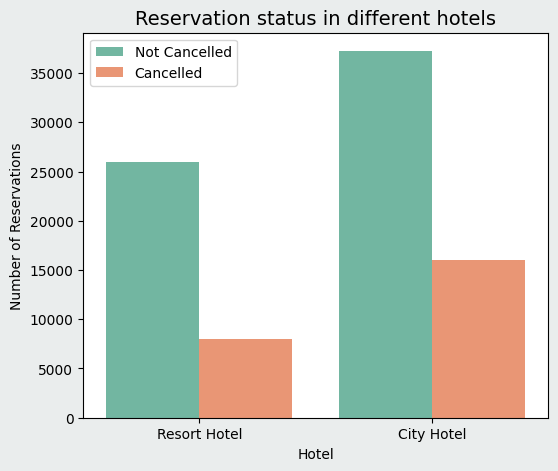

In [47]:
# Set the background color of the figure
plt.figure(figsize=(6, 5), facecolor='#EAEDED')

# Create the countplot
ax1 = sns.countplot(x='hotel', hue='is_canceled', data=final_hotel_bookings_df, palette="Set2")

# Customize legend location
legend_labels, _ = ax1.get_legend_handles_labels()
ax1.legend(bbox_to_anchor=(1, 1))

# Set plot title and axis labels
plt.title('Reservation status in different hotels', size=14, color='Black')
plt.xlabel('Hotel',color='Black')
plt.ylabel('Number of Reservations', color='Black')

# Customize legend labels
plt.legend(['Not Cancelled', 'Cancelled'])

# Show the plot
plt.show()

**Arriving year, Leadtime and Cancelations**

In [99]:
final_hotel_bookings_df.columns.values

array(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date',
       'arrival_location', 'avg_temp', 'min_temp', 'max_temp',
       'feels_like_temp', 'humidity', 'precipitation',
       'precipitation_probability', 'snowfall', 'max_wind_gust',
       'avg_wind_speed', 'visibility_km', 'cloud_cover',
       'weather_conditions', 'is_holiday_week', 'nearest_hol

Text(0.5, 1.0, 'Arriving year, Leadtime and Cancelations')

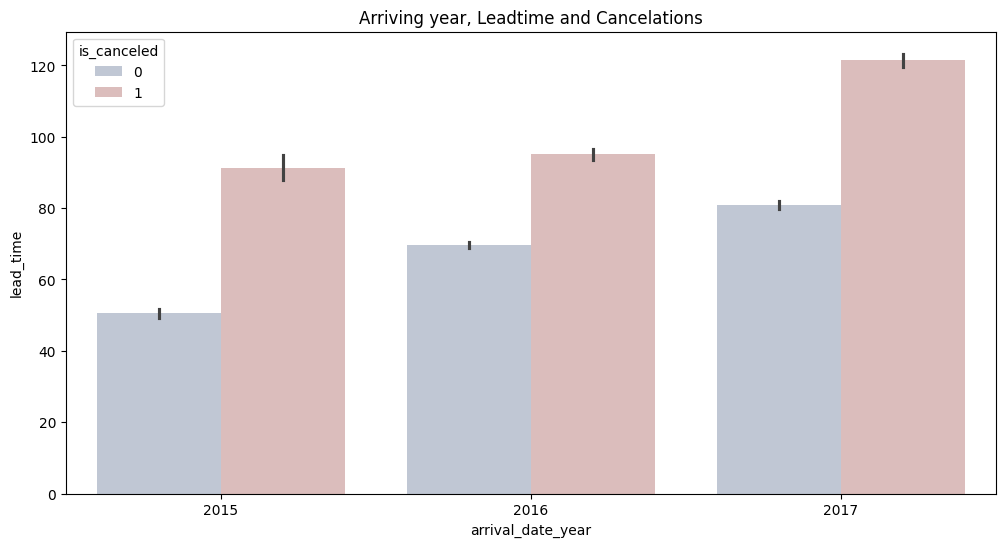

In [48]:
plt.figure(figsize=(12,6))
sns.barplot(x='arrival_date_year', y='lead_time',hue='is_canceled', data= final_hotel_bookings_df, palette='vlag')
plt.title('Arriving year, Leadtime and Cancelations')

**Which are the most busy months?**

In [49]:
resort_guests = data_resort['arrival_date_month'].value_counts().reset_index()
resort_guests.columns=['month','no of guests']
resort_guests

,month,no of guests
0,August,3153
1,July,3013
2,May,2246
3,October,2209
4,March,2191
5,April,2169
6,February,2053
7,June,1926
8,September,1875
9,November,1744


In [50]:
city_guests = data_city['arrival_date_month'].value_counts().reset_index()
city_guests.columns=['month','no of guests']
city_guests

,month,no of guests
0,August,4467
1,July,3834
2,May,3656
3,June,3477
4,March,3469
5,April,3325
6,September,3166
7,October,3070
8,February,2618
9,November,2177


In [51]:
final_guests = resort_guests.merge(city_guests,on='month')
final_guests.columns=['month','no of guests in resort','no of guest in city hotel']
final_guests

,month,no of guests in resort,no of guest in city hotel
0,August,3153,4467
1,July,3013,3834
2,May,2246,3656
3,October,2209,3070
4,March,2191,3469
5,April,2169,3325
6,February,2053,2618
7,June,1926,3477
8,September,1875,3166
9,November,1744,2177


In [52]:
final_guests = sort_month(final_guests,'month')
final_guests

,month,no of guests in resort,no of guest in city hotel
0,January,1687,1961
1,February,2053,2618
2,March,2191,3469
3,April,2169,3325
4,May,2246,3656
5,June,1926,3477
6,July,3013,3834
7,August,3153,4467
8,September,1875,3166
9,October,2209,3070


In [53]:
px.line(final_guests, x = 'month', y = ['no of guests in resort','no of guest in city hotel'],
        title='Total no of guests per Months', template = 'plotly_dark')

**How long do people stay at the hotels?**

In [54]:
filter = final_hotel_bookings_df['is_canceled'] == 0
data = final_hotel_bookings_df[filter]
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,precipitation_probability,snowfall,max_wind_gust,avg_wind_speed,visibility_km,cloud_cover,weather_conditions,is_holiday_week,nearest_holiday,days_to_holiday
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0


In [55]:
data['total_nights'] = data['stays_in_weekend_nights'] + data['stays_in_week_nights']
data.head()

<ipython-input-55-a6d36badedd5>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,snowfall,max_wind_gust,avg_wind_speed,visibility_km,cloud_cover,weather_conditions,is_holiday_week,nearest_holiday,days_to_holiday,total_nights
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0,0
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0,0
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0,1
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0,1
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,0,54.0,38.5,11.0,35.6,Partially cloudy,True,Madeira Day,0,2


In [56]:
stay = data.groupby(['total_nights', 'hotel']).agg('count').reset_index()
stay = stay.iloc[:, :3]
stay = stay.rename(columns={'is_canceled':'Number of stays'})
stay

,total_nights,hotel,Number of stays
0,0,City Hotel,218
1,0,Resort Hotel,350
2,1,City Hotel,7972
3,1,Resort Hotel,6036
4,2,City Hotel,7630
...,...,...,...
57,46,Resort Hotel,1
58,48,City Hotel,1
59,56,Resort Hotel,1
60,60,Resort Hotel,1


In [57]:
px.bar(data_frame = stay, x = 'total_nights', y = 'Number of stays', color = 'hotel', barmode = 'group',title='Total no of stays per nights',
        template = 'plotly_dark')

In [120]:
final_hotel_bookings_df.columns.values

array(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date',
       'arrival_location', 'avg_temp', 'min_temp', 'max_temp',
       'feels_like_temp', 'humidity', 'precipitation',
       'precipitation_probability', 'snowfall', 'max_wind_gust',
       'avg_wind_speed', 'visibility_km', 'cloud_cover',
       'weather_conditions', 'is_holiday_week', 'nearest_hol

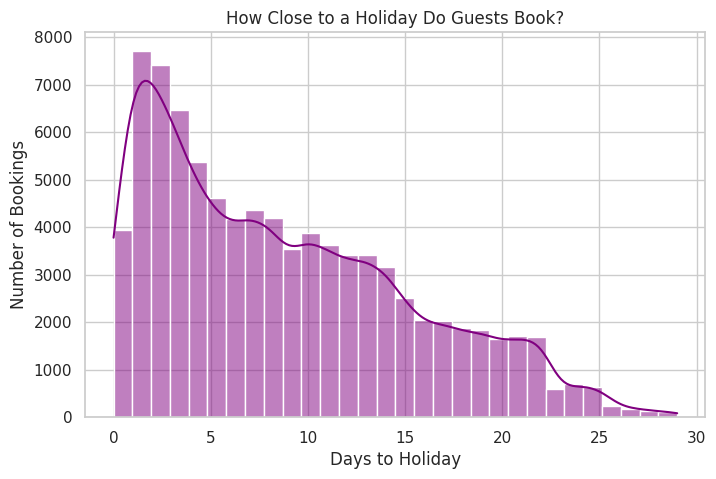

<ipython-input-136-62c577371d33>:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




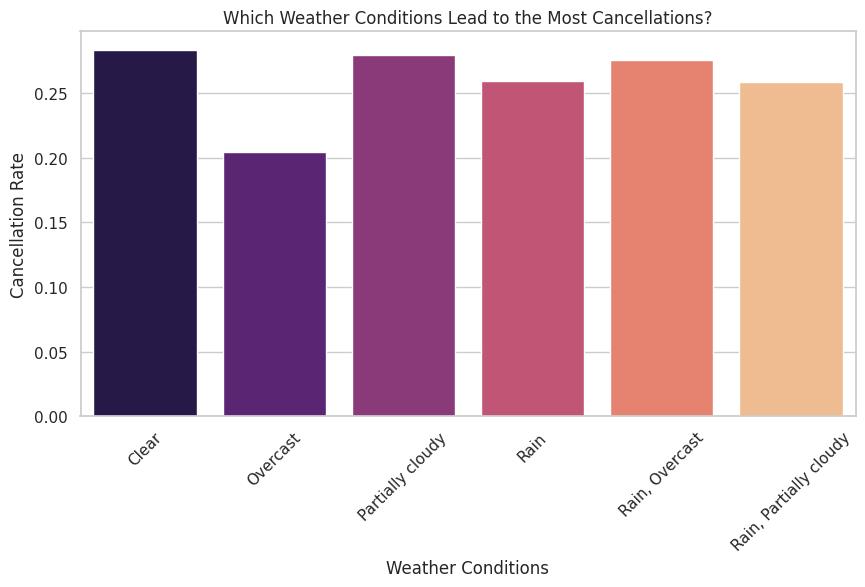

<ipython-input-136-62c577371d33>:46: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


<ipython-input-136-62c577371d33>:46: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




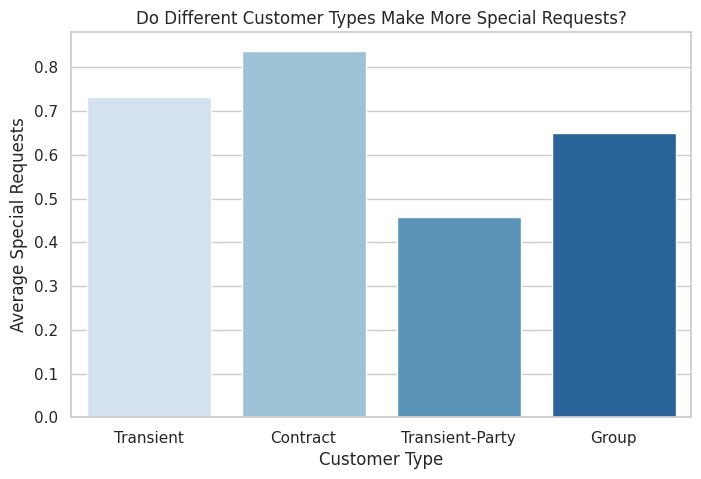

In [136]:
df = final_hotel_bookings_df.copy()


# Convert dates to datetime format
df['arrival_date'] = pd.to_datetime(df['arrival_date'])

# Set Seaborn style
sns.set(style="whitegrid")

# ---- 1. Seaborn: How Close to a Holiday Do Guests Book? ----
plt.figure(figsize=(8, 5))
sns.histplot(df["days_to_holiday"], bins=30, kde=True, color="purple")
plt.title("How Close to a Holiday Do Guests Book?")
plt.xlabel("Days to Holiday")
plt.ylabel("Number of Bookings")
plt.show()

# ---- 2. Matplotlib: How Does Weather Impact Cancellation Rates? ----
plt.figure(figsize=(10, 5))
weather_cancellation = df.groupby("weather_conditions")["is_canceled"].mean().reset_index()
sns.barplot(x="weather_conditions", y="is_canceled", data=weather_cancellation, palette="magma")
plt.xticks(rotation=45)
plt.title("Which Weather Conditions Lead to the Most Cancellations?")
plt.xlabel("Weather Conditions")
plt.ylabel("Cancellation Rate")
plt.show()

# ---- 3. Plotly: Lead Time Distribution by Market Segment ----
fig3 = px.box(df, x="market_segment", y="lead_time", color="market_segment",
              title="How Far in Advance Do Guests Book? (By Market Segment)",
              labels={'market_segment': "Market Segment", 'lead_time': "Lead Time (Days)"},
              boxmode="group")
fig3.show()

# ---- 4. Plotly: ADR Trends Over Time ----
df["arrival_month_year"] = df["arrival_date"].dt.to_period("M").astype(str)
adr_trend = df.groupby("arrival_month_year")["adr"].mean().reset_index()
fig4 = px.line(adr_trend, x="arrival_month_year", y="adr",
               title="How Does ADR Change Over Time?",
               labels={'arrival_month_year': "Month", 'adr': "Average Daily Rate"},
               markers=True)
fig4.show()

# ---- 5. Seaborn: Impact of Customer Type on Special Requests ----
plt.figure(figsize=(8, 5))
sns.barplot(x="customer_type", y="total_of_special_requests", data=df, palette="Blues", ci=None)
plt.title("Do Different Customer Types Make More Special Requests?")
plt.xlabel("Customer Type")
plt.ylabel("Average Special Requests")
plt.show()
